# Práctica: Transformada Cuántica de Fourier

Implemente y analice en el simulador Quirk y en el Qiskit los siguientes ejercicios:
1. La QFT y la QFT-1 de 4 qubits.
2. El ejemplo de suma de 5 qubits (en estados básicos) usando el dominio de Fourier y QFT-1 (ejemplo de teoría).
3. Un multiplicador entre un número binario codificado en 3 qubits (mediante estados básicos) y un escalar 5, basado en dominio de Fourier.
4. Un multiplicador entre dos números binarios codificados en 3 qubits (mediante estados básicos), basado en dominio de Fourier.

## Imports

In [149]:
import math
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

# Para la visualización de los resultados en tablas:
import os
import matplotlib.pyplot as plt # Utilizada para generación de tablas.

## Ejercicio 1

Implementar la a QFT y la QFT-1 de 4 qubits.

### QFT

![QFT4](../images//qft4.png)

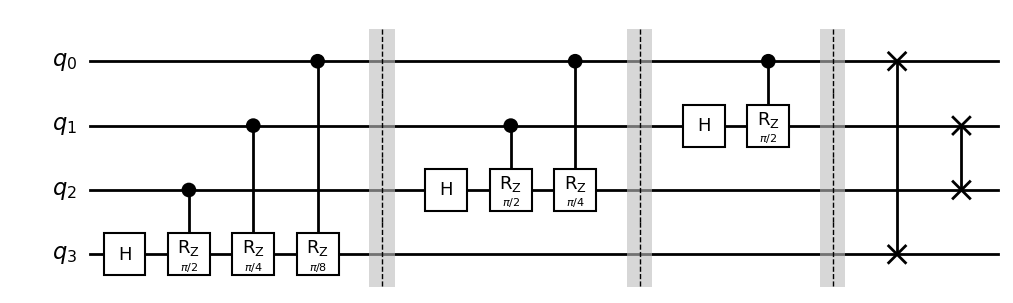

In [150]:
def qft(number_of_qubits):
    
    quantum_circuit = QuantumCircuit(number_of_qubits, name="QTF")
    
    accesible_qubits = number_of_qubits - 1
        
    # Por cada qubit, se aplica una rotación extra.
    # Al primer qubit, solo se le aplica Hadamard.
    # Al segundo, una rotación de pi/2 y Hadamard.
    # Al tercero, una rotación de pi/4, una rotación de pi/2 y Hadamard.
    for i in range(accesible_qubits, 0, -1):
        
        # Se aplica Hadamard previo a las rotaciones.
        quantum_circuit.h(i)
        
        for j in range(i):
            quantum_circuit.crz(math.pi/(2 ** (j+1)), i - j - 1, i)
        
        # Se aplica una barrera para evitar el autoordenamiento de Qiskit.
        quantum_circuit.barrier()
        
    # Swap entre el qubit 0 y el n - 1.
    # Swap entre el qubit 1 y el n - 2.
    # Y así hasta llegar al centro.
    for i in range(int(number_of_qubits/2)):
        quantum_circuit.swap(i, accesible_qubits - i)
        
    return quantum_circuit
        
qc = qft(4)
qc.draw(output='mpl', style='bw')

### IQTF

![IQFT4](../images/iqft4.png)

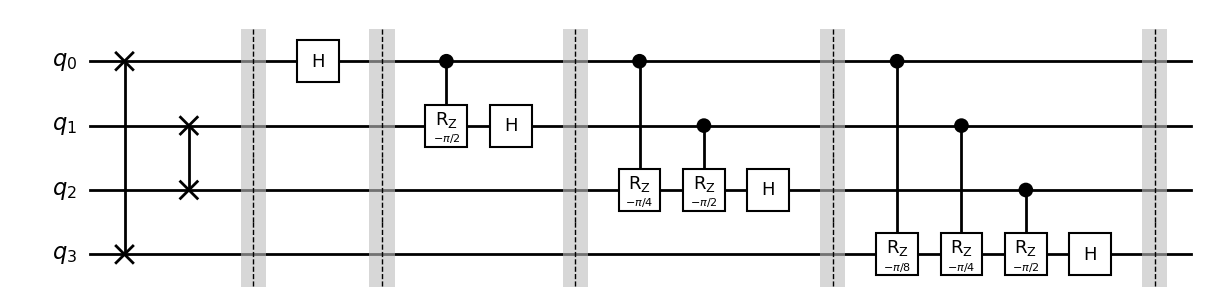

In [151]:
def iqtf(number_of_qubits):
    
    quantum_circuit = QuantumCircuit(number_of_qubits, name="IQTF")
    
    accesible_qubits = number_of_qubits - 1
    
    # Swap entre el qubit 0 y el n - 1.
    # Swap entre el qubit 1 y el n - 2.
    # Y así hasta llegar al centro.
    
    # Los swaps pueden ahorrarse si se invierte el orden de los qubits resultados.
    for i in range(int(number_of_qubits/2)):
        quantum_circuit.swap(i, accesible_qubits - i)
        
    quantum_circuit.barrier()
        
    # Por cada qubit, se aplica una rotación extra.
    # Al primer qubit, solo se le aplica Hadamard.
    # Al segundo, una rotación de pi/2 y Hadamard.
    # Al tercero, una rotación de pi/4, una rotación de pi/2 y Hadamard.
    for i in range(number_of_qubits):
        
        for j in range(i, 0, -1):
            # crz(angulo, control, objetivo)
            quantum_circuit.crz(-math.pi/(2 ** j), i - j, i)
        
        # Se aplica un Hadamard luego de las rotaciones.
        quantum_circuit.h(i)
        
        # Se aplica una barrera para evitar el autoordenamiento de Qiskit.
        quantum_circuit.barrier()
        
    return quantum_circuit
        
qc = iqtf(4)
qc.draw(output='mpl', style='bw')

## Ejercicio 2

El ejemplo de suma de 5 qubits (en estados básicos) usando el dominio de Fourier y QFT-1 (ejemplo de teoría)

![Suma de 5 qubits (en estados básicos) usando el dominio de Fourier y QFT-1](../images/suma5qubitsQFT.png)

In [152]:
def calcular_qubits_resultantes_de_suma(qubits_en_cada_operando, operandos):
    
    """
    Cada dos operandos, puede haber un acarreo.
    - 1 operando -> Qubits en el operando.
    - 2 operandos -> Qubits en los operandos + 1. (Posibilidad de acarreo).
    - 3 operandos -> Qubits en los operandos + 1. (Posibilidad de acarreo).
    - 4 operandos -> Qubits en los operandos + 2. (Posibilidad de acarreo y acarreo en el acarreo).
    - 5 operandos -> Qubits en los operandos + 2.
    - 6 operandos -> Qubits en los operandos + 2.
    - 7 operandos -> Qubits en los operandos + 2-
    - 8 operandos -> Qubits en los operandos + 3.
    - ...
    - n operands -> Qubits in each operand + floor(log2(operands))
    """
    
    return qubits_en_cada_operando + math.floor(math.log2(operandos))

calcular_qubits_resultantes_de_suma(1, 8)

4

Se considera al qubit menos significativo al de arriba, por lo que es a quien se le aplica la mayor rotación.

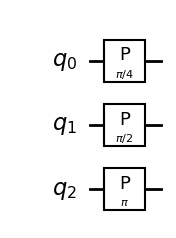

In [153]:
def plus1(qubits):
    
    accesible_qubits = qubits - 1
    quantum_circuit = QuantumCircuit(qubits, name="TSZ")
    
    for qubit in range(qubits):
        # Cambio de fase.
        quantum_circuit.p(math.pi/(2 ** qubit), accesible_qubits - qubit) # Si se considera a q0 como el MSB.
        #quantum_circuit.p(math.pi/(2 ** qubit), qubit) # Considerando a q0 como el LSB. Permite no utilizar swaps en la IQFT.
        
    return quantum_circuit

plus1(3).draw(output='mpl', style='bw')

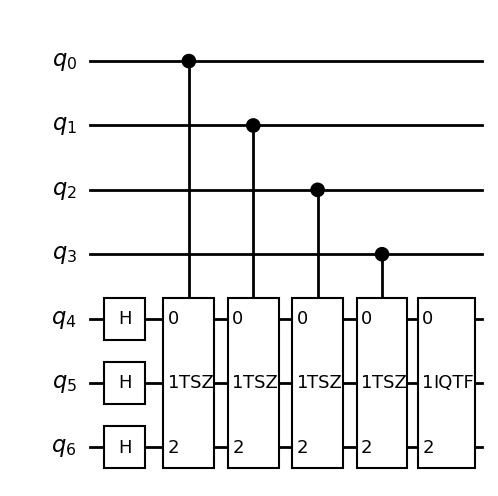

In [154]:
def calcular_suma_monoqubit(operands):
    
    result_qubits = calcular_qubits_resultantes_de_suma(1, operands)
    
    quantum_circuit = QuantumCircuit(operands + result_qubits, name="Adder")
    
    # Se entra en el dominio de Fourier.
    #quantum_circuit.append(qft(operands), list(range(operands, operands + result_qubits)))
    
    for i in range(operands, operands + result_qubits, 1):
        quantum_circuit.h(i)
        
    for i in range(operands):
        # Creación de la columna de fases (T, S, Z...).
        gate_columna = plus1(result_qubits)
        
        # La columna es controlada solo por un qubit.
        controlled_gate = gate_columna.to_gate().control(1)
        
        # Se definen los "cables": [Control, Objetivo1, Objetivo2, Objetivo3...].
        # Control: es el qubit 'i' (input).
        # Objetivos: son los qubits del acumulador (del 5 al 7).
        qubit_control = [i]
        qubits_objetivo = list(range(operands, operands + result_qubits))
        
        wiring = qubit_control + qubits_objetivo
        
        # Añadido del cableado al circuito.
        quantum_circuit.append(controlled_gate, wiring)
        
    # Se añade la transformada cuántica de Fourier inversa para decodificar el resultado.
    quantum_circuit.append(iqtf(result_qubits), list(range(operands, operands + result_qubits)))
        
    
    return quantum_circuit

number_of_qubits = 4
result_qubits = calcular_qubits_resultantes_de_suma(1, number_of_qubits)
qc = calcular_suma_monoqubit(number_of_qubits)
qc.draw(output='mpl', style='bw')

Añadido de las mediciones:

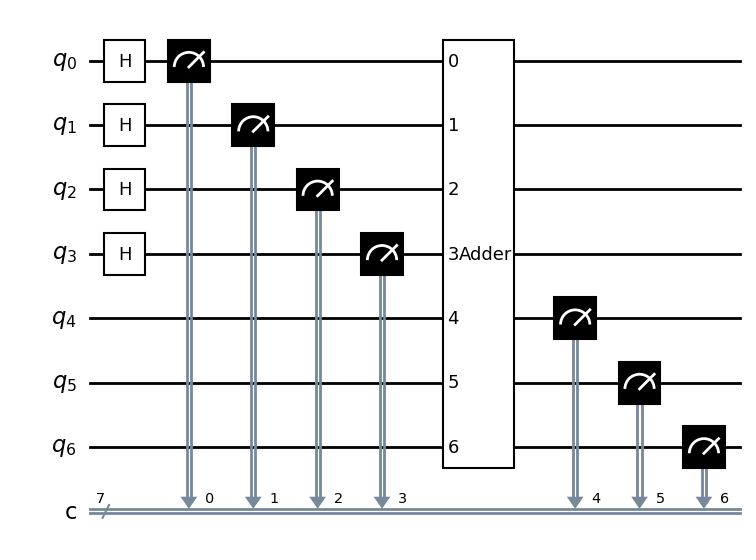

In [155]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits + result_qubits, number_of_qubits + result_qubits)

# Superposición de los operandos.
measured_quantum_circuit.h(list(range(number_of_qubits)))

# Medición de los valores de los operandos.
measured_quantum_circuit.measure(list(range(number_of_qubits)), list(range(number_of_qubits)))

measured_quantum_circuit.append(qc, list(range(number_of_qubits + result_qubits)))

for i in range(number_of_qubits, number_of_qubits + result_qubits, 1):
    measured_quantum_circuit.measure(i, i)

measured_quantum_circuit.draw(output='mpl', style='bw')

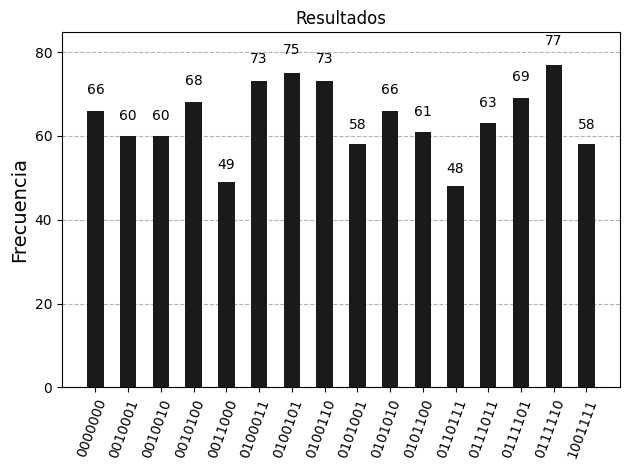

In [156]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

histogram = plot_histogram(counts, title="Resultados", color="#1D1A1A")
histogram.axes[0].set_ylabel("Frecuencia")

histogram

In [157]:
def imprimir_tabla_generalizada(counts, n_inputs, n_outputs):
    """
    Imprime una tabla de verdad dinámica verificando si la suma es correcta.
    Asume que el bitstring de Qiskit viene en orden: MSB ... LSB
    Donde los Inputs están en los bits bajos (derecha) y el Resultado en los altos (izquierda).
    """
    
    # 1. Configuración de Anchos
    W_QUBIT = 4   # Ancho para cada columna de bit (Q0, S0, etc)
    W_FREQ = 12   # Ancho para la frecuencia
    W_CHECK = 10  # Ancho para el estado Correcto/Incorrecto
    
    # Generamos las etiquetas de las columnas dinámicamente
    # Entradas: Q0, Q1, ...
    headers_inputs = [f"Q{i}" for i in range(n_inputs)]
    # Salidas: S0, S1, ... (Bit de acarreo sería el S más alto)
    headers_outputs = [f"S{i}" for i in range(n_outputs)]
    
    # Calculamos el ancho total
    # (Ancho * cantidad de columnas) + (3 chars por separador '| x ')
    total_columns = n_inputs + n_outputs
    TOTAL_WIDTH = (total_columns * (W_QUBIT + 3)) + W_FREQ + W_CHECK + 7

    # Funciones auxiliares de formato
    def print_line():
        print(f"|{'-' * (TOTAL_WIDTH - 2)}|")

    # 2. Imprimir Encabezado
    print_line()
    title = f"Tabla de Verdad Generalizada ({n_inputs} Inputs -> {n_outputs} Outputs)"
    print(f"|{title:^{TOTAL_WIDTH - 2}}|")
    print_line()

    # Construcción de la fila de títulos
    header_str = "|"
    # Imprimimos Inputs
    for h in headers_inputs:
        header_str += f" {h:^{W_QUBIT}} |"
    # Imprimimos Outputs (Separador visual)
    header_str += "|" # Doble barra para separar input de output
    for h in headers_outputs:
        header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += f" {'Freq':^{W_FREQ}} | {'¿OK?':^{W_CHECK}} |"
    
    print(header_str)
    print_line()

    # 3. Procesar Datos
    # Ordenamos por bitstring para que la tabla se vea ordenada (000, 001...)
    for bitstring, count in sorted(counts.items()):
        
        # Limpiamos el bitstring (por si Qiskit pone espacios) y quitamos '0b' si existe
        clean_bits = bitstring.replace(" ", "")
        
        # --- PARSEO DINÁMICO ---
        # En Qiskit, el string se lee de Derecha a Izquierda para índices 0, 1, 2...
        # String: "... S1 S0 Q1 Q0"
        
        # 1. Extraer Inputs (Los n_inputs de la derecha)
        # Tomamos los últimos n chars e invertimos para tener [q0, q1, q2...]
        input_chars = clean_bits[-n_inputs:]
        input_bits = [int(b) for b in reversed(input_chars)]
        
        # 2. Extraer Outputs (Los siguientes n_outputs hacia la izquierda)
        # Tomamos el slice correspondiente
        output_chars = clean_bits[-(n_inputs + n_outputs) : -n_inputs]
        output_bits = [int(b) for b in reversed(output_chars)] # [s0, s1, s2...]

        # --- LÓGICA DE VALIDACIÓN ---
        # 1. Valor Esperado: Suma de los inputs (Population Count)
        # Ej: Si inputs son 1, 0, 1 -> Esperado = 2
        valor_esperado = sum(input_bits)
        
        # 2. Valor Real: Convertir binario de salida a decimal
        # output_chars ya viene con el MSB a la izquierda, así que int(str, 2) funciona directo
        valor_real = int(output_chars, 2)
        
        es_correcto = "SÍ" if valor_esperado == valor_real else "NO"
        
        # --- IMPRESIÓN DE FILA ---
        row_str = "|"
        
        # Inputs
        for bit in input_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += "|" # Separador doble
        
        # Outputs
        for bit in output_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += f" {count:^{W_FREQ}} | {es_correcto:^{W_CHECK}} |"
        
        print(row_str)

    print_line()

# --- EJEMPLO DE USO ---
# Suponiendo que 'counts' es tu resultado de Qiskit
# Inputs = 2 (q0, q1)
# Resultados = 3 (q2, q3, q4)
imprimir_tabla_generalizada(counts, n_inputs=number_of_qubits, n_outputs=result_qubits)

|----------------------------------------------------------------------------|
|            Tabla de Verdad Generalizada (4 Inputs -> 3 Outputs)            |
|----------------------------------------------------------------------------|
|  Q0  |  Q1  |  Q2  |  Q3  ||  S0  |  S1  |  S2  |     Freq     |    ¿OK?    |
|----------------------------------------------------------------------------|
|  0   |  0   |  0   |  0   ||  0   |  0   |  0   |      66      |     SÍ     |
|  1   |  0   |  0   |  0   ||  1   |  0   |  0   |      60      |     SÍ     |
|  0   |  1   |  0   |  0   ||  1   |  0   |  0   |      60      |     SÍ     |
|  0   |  0   |  1   |  0   ||  1   |  0   |  0   |      68      |     SÍ     |
|  0   |  0   |  0   |  1   ||  1   |  0   |  0   |      49      |     SÍ     |
|  1   |  1   |  0   |  0   ||  0   |  1   |  0   |      73      |     SÍ     |
|  1   |  0   |  1   |  0   ||  0   |  1   |  0   |      75      |     SÍ     |
|  0   |  1   |  1   |  0   ||  0   |  1   |

In [158]:
def imprimir_tabla_descendente(counts, n_inputs, n_outputs):
    """
    Imprime una tabla de verdad generalizada en ORDEN DESCENDENTE (MSB -> LSB).
    Ejemplo: Q1 | Q0 || S2 | S1 | S0
    """
    
    # 1. Configuración de Anchos
    W_QUBIT = 4   
    W_FREQ = 12   
    W_CHECK = 10  
    
    # --- CAMBIO 1: Encabezados Invertidos ---
    # Generamos Q(n-1) ... Q0
    headers_inputs = [f"Q{i}" for i in reversed(range(n_inputs))]
    # Generamos S(n-1) ... S0
    headers_outputs = [f"S{i}" for i in reversed(range(n_outputs))]
    
    # Calculamos ancho total
    total_columns = n_inputs + n_outputs
    TOTAL_WIDTH = (total_columns * (W_QUBIT + 3)) + W_FREQ + W_CHECK + 7

    def print_line():
        print(f"|{'-' * (TOTAL_WIDTH - 2)}|")

    # 2. Imprimir Encabezado
    print_line()
    title = f"Tabla Descendente ({n_inputs} Inputs -> {n_outputs} Outputs)"
    print(f"|{title:^{TOTAL_WIDTH - 2}}|")
    print_line()

    header_str = "|"
    # Inputs (Izquierda)
    for h in headers_inputs:
        header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += "|" # Separador visual
    
    # Outputs (Derecha)
    for h in headers_outputs:
        header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += f" {'Freq':^{W_FREQ}} | {'¿OK?':^{W_CHECK}} |"
    print(header_str)
    print_line()

    # 3. Procesar Datos
    for bitstring, count in sorted(counts.items()):
        
        clean_bits = bitstring.replace(" ", "")
        
        # --- CAMBIO 2: No invertimos los slices ---
        # Qiskit ya entrega el string como "... Q1 Q0" (MSB a la izquierda).
        # Como queremos imprimir Q1 luego Q0, leemos el string tal cual viene.
        
        # 1. Extraer Inputs (Los últimos n caracteres)
        # String: "S2 S1 S0 Q1 Q0"
        # slice [-2:] -> "Q1 Q0" -> [val_Q1, val_Q0]
        input_chars = clean_bits[-n_inputs:]
        input_bits = [int(b) for b in input_chars] 
        
        # 2. Extraer Outputs (Los anteriores a los inputs)
        # slice -> "S2 S1 S0" -> [val_S2, val_S1, val_S0]
        output_chars = clean_bits[-(n_inputs + n_outputs) : -n_inputs]
        output_bits = [int(b) for b in output_chars]

        # --- VALIDACIÓN ---
        # Suma de bits activos en la entrada
        valor_esperado = sum(input_bits)
        
        # Valor decimal de la salida binaria
        valor_real = int(output_chars, 2)
        
        es_correcto = "SÍ" if valor_esperado == valor_real else "NO"
        
        # --- IMPRESIÓN ---
        row_str = "|"
        
        for bit in input_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += "|" 
        
        for bit in output_bits:
            row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += f" {count:^{W_FREQ}} | {es_correcto:^{W_CHECK}} |"
        print(row_str)

    print_line()

# --- USO ---
imprimir_tabla_descendente(counts, n_inputs=number_of_qubits, n_outputs=result_qubits)

|----------------------------------------------------------------------------|
|                 Tabla Descendente (4 Inputs -> 3 Outputs)                  |
|----------------------------------------------------------------------------|
|  Q3  |  Q2  |  Q1  |  Q0  ||  S2  |  S1  |  S0  |     Freq     |    ¿OK?    |
|----------------------------------------------------------------------------|
|  0   |  0   |  0   |  0   ||  0   |  0   |  0   |      66      |     SÍ     |
|  0   |  0   |  0   |  1   ||  0   |  0   |  1   |      60      |     SÍ     |
|  0   |  0   |  1   |  0   ||  0   |  0   |  1   |      60      |     SÍ     |
|  0   |  1   |  0   |  0   ||  0   |  0   |  1   |      68      |     SÍ     |
|  1   |  0   |  0   |  0   ||  0   |  0   |  1   |      49      |     SÍ     |
|  0   |  0   |  1   |  1   ||  0   |  1   |  0   |      73      |     SÍ     |
|  0   |  1   |  0   |  1   ||  0   |  1   |  0   |      75      |     SÍ     |
|  0   |  1   |  1   |  0   ||  0   |  1   |

## Ejercicio 3

Un multiplicador entre un número binario codificado en 3 qubits (mediante estados básicos) y un escalar 5, basado en dominio de Fourier

Para un número de 3 qubits, el máximo valor es 7. 7 x 5 = 35, que es el máximo valor alcanzable. Este es 2^5 (32) + 2^1 (2) + 2^0 (1): 100011. Se necesitan seis qubits para llevar el resultado.

Por cada qubit activo, se debe sumar 5 al sumador. Por lo tanto, se crea el circuito plus5. 5 es, en binario, 101. Por lo tanto, cada vez que hay un 5, debe aplicarse una rotación:

¿Cuándo cambia cada uno de los qubits?

1 5 -> 000101
2 5s -> 001010
3 5s -> 001111
4 5s -> 010100
5 5s -> 011001
6 5s -> 011110
7 5s -> 100011

- q4: Su valor cambia cada pi/7.
- q5: 0 -> 0 - 0 -> 1 -> 1 -> 1 -> 0. Su valor cambia, en cada activación, pi/3.
- q6: 0 -> 1 -> 1 -> 0 -> 1 -> 1 -> 0. Su valor es el resultado de la suma de los dos resultados anteriores.
- q7: 1 -> 0 -> 1 -> 1 -> 0 -> 1 -> 0. Cambia su valor cada pi, salvo que los dos qubits con menos peso sean también 1.
- q8: Se aplica pi/2 por cada activación. Cambia su valor cada 2 cincos.
- q9: LSB. Cambia su valor en cada rotación. Se aplica una rotación de pi por cada activación.

En el Sumador de Draper (Base de Fourier), la lógica es infinitamente más simple y lineal. No necesitas ver la tabla de verdad.

Aquí está la Regla de Oro para sumar cualquier número V constante (en este caso V=5):

    El ángulo de rotación para el qubit k es simplemente el ángulo de "sumar 1" multiplicado por V.

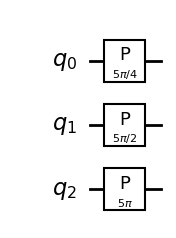

In [159]:
def plusN(n, result_qubits):
    
    # Creación del circuito.
    qc = QuantumCircuit(result_qubits, name=f"+{n}")
    
    for i in range(result_qubits):
        
        # Fórmula: Angulo Base * Valor
        angulo = (math.pi / (2 ** i)) * n
        
        # Aplicación de la rotación.
        qc.p(angulo, result_qubits - 1 - i) 
        
    return qc

plusN(5, 3).draw(output='mpl', style='bw')

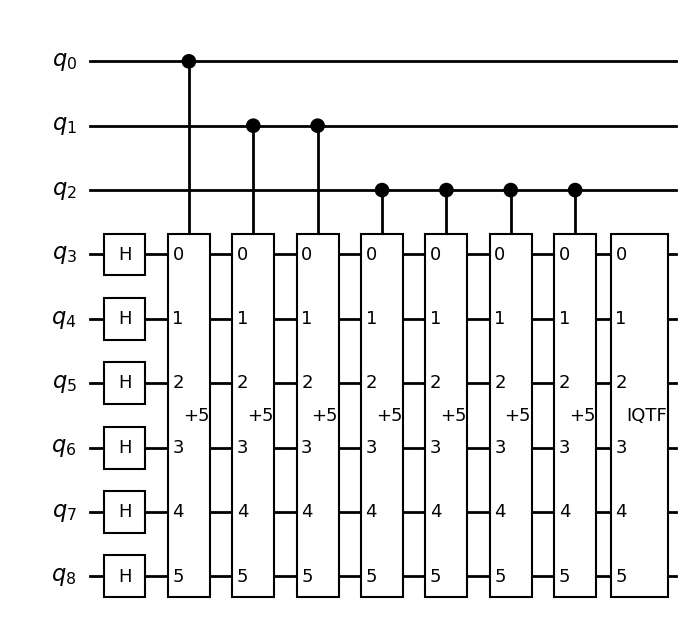

In [160]:
def multiplier(qubits_in_operand, value):
    
    def multiplication_result_qubits(qubits_in_first_operand, qubits_in_second_operand):
    
        """
        En el peor de los casos, la multiplicación de un operando de m bits y un operando
        de n bits tiene como resultado a un número de m + n bits.
        """
        
        return qubits_in_first_operand + qubits_in_second_operand
    
    result_qubits = multiplication_result_qubits(qubits_in_operand, value.bit_length())
    
    quantum_circuit = QuantumCircuit(qubits_in_operand + result_qubits, name=f"x{value}")
    
    for i in range(qubits_in_operand, qubits_in_operand + result_qubits, 1):
        quantum_circuit.h(i)
        
    for i in range(qubits_in_operand):
        
        gate_columna = plusN(value, result_qubits)
        
        # La columna es controlada solo por un qubit.
        controlled_gate = gate_columna.to_gate().control(1)
        
        # Se definen los "cables": [Control, Objetivo1, Objetivo2, Objetivo3...].
        # Control: es el qubit 'i' (input).
        # Objetivos: son los qubits del acumulador (del 5 al 7).
        qubit_control = [i]
        qubits_objetivo = list(range(qubits_in_operand, qubits_in_operand + result_qubits))
        
        wiring = qubit_control + qubits_objetivo
        
        # De acuerdo al peso, es la cantidad de rotaciones que deben colocarse.
        for _ in range(2 ** i):
            # Añadido del cableado al circuito.
            quantum_circuit.append(controlled_gate, wiring)
        
    # Se añade la transformada cuántica de Fourier inversa para decodificar el resultado.
    quantum_circuit.append(iqtf(result_qubits), list(range(qubits_in_operand, qubits_in_operand + result_qubits)))
    
    return quantum_circuit, result_qubits

constant = 5
number_of_qubits = 3
qc, result_qubits = multiplier(number_of_qubits, constant)
qc.draw(output='mpl', style='bw')

Añadido de las mediciones:

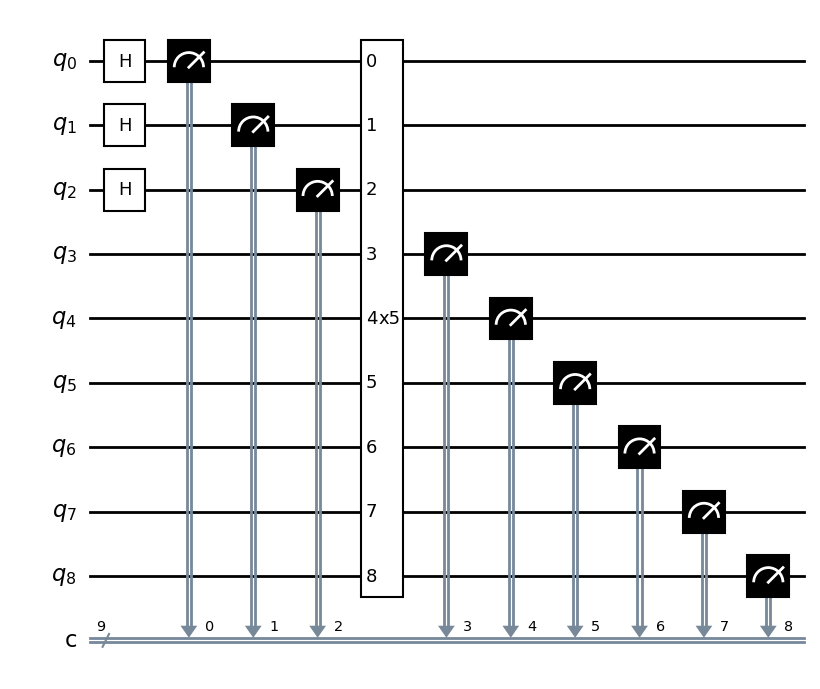

In [161]:
measured_quantum_circuit = QuantumCircuit(number_of_qubits + result_qubits, number_of_qubits + result_qubits)

# Superposición de los operandos.
measured_quantum_circuit.h(list(range(number_of_qubits)))

# Medición de los valores de los operandos.
measured_quantum_circuit.measure(list(range(number_of_qubits)), list(range(number_of_qubits)))

measured_quantum_circuit.append(qc, list(range(number_of_qubits + result_qubits)))

for i in range(number_of_qubits, number_of_qubits + result_qubits, 1):
    measured_quantum_circuit.measure(i, i)

measured_quantum_circuit.draw(output='mpl', style='bw')

Simulación:

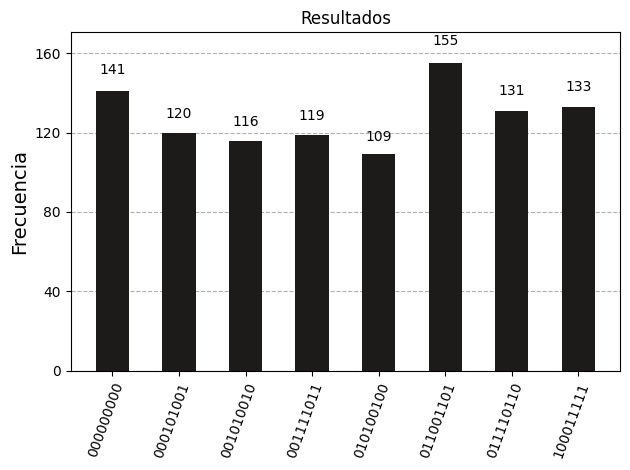

In [162]:
simulator = AerSimulator()
transpiled = transpile(measured_quantum_circuit, simulator)
job = simulator.run(transpiled, shots=1024)
results = job.result()
counts = results.get_counts(transpiled)

histogram = plot_histogram(counts, title="Resultados", color="#1D1A1A")
histogram.axes[0].set_ylabel("Frecuencia")

histogram

In [163]:
def imprimir_tabla_generica(counts, n_inputs, n_outputs, funcion_validacion=None):
    """
    Imprime una tabla de verdad validando contra una función arbitraria.
    :param funcion_validacion: Función que recibe (input_int) y retorna (expected_output_int)
    """
    
    # 1. Configuración de Anchos
    W_QUBIT = 4   
    W_FREQ = 12   
    W_CHECK = 10  
    W_EXPECTED = 10 # Nueva columna opcional para ver qué esperábamos
    
    # Generamos headers Q(n-1)...Q0 y S(n-1)...S0
    headers_inputs = [f"Q{i}" for i in reversed(range(n_inputs))]
    headers_outputs = [f"S{i}" for i in reversed(range(n_outputs))]
    
    total_columns = n_inputs + n_outputs
    # Ajustamos ancho total
    TOTAL_WIDTH = (total_columns * (W_QUBIT + 3)) + W_FREQ + W_CHECK + W_EXPECTED + 10

    def print_line():
        print(f"|{'-' * (TOTAL_WIDTH - 2)}|")

    # 2. Imprimir Encabezado
    print_line()
    title = f"Validación: {funcion_validacion.__name__ if funcion_validacion else 'Ninguna'}"
    print(f"|{title:^{TOTAL_WIDTH - 2}}|")
    print_line()

    header_str = "|"
    for h in headers_inputs: header_str += f" {h:^{W_QUBIT}} |"
    header_str += "|" 
    for h in headers_outputs: header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += f" {'Freq':^{W_FREQ}} | {'Esp.':^{W_EXPECTED}} | {'¿OK?':^{W_CHECK}} |"
    print(header_str)
    print_line()

    # 3. Procesar Datos
    for bitstring, count in sorted(counts.items()):
        
        clean_bits = bitstring.replace(" ", "")
        
        # A. Separar Inputs y Outputs (Strings binarios)
        input_chars = clean_bits[-n_inputs:]
        output_chars = clean_bits[-(n_inputs + n_outputs) : -n_inputs]
        
        # B. Convertir a Enteros Decimales (¡Paso clave!)
        val_input_decimal = int(input_chars, 2)
        val_output_real = int(output_chars, 2)
        
        # C. Lógica de Validación Dinámica
        es_correcto = "-"
        val_esperado_str = "-"
        
        if funcion_validacion:
            # Calculamos qué debió salir según la matemática
            val_esperado = funcion_validacion(val_input_decimal)
            val_esperado_str = str(val_esperado)
            
            # Comparamos
            if val_esperado == val_output_real:
                es_correcto = "SÍ"
            else:
                es_correcto = "NO"

        # D. Impresión (Bits individuales para visualización)
        input_bits = [b for b in input_chars]
        output_bits = [b for b in output_chars]
        
        row_str = "|"
        for bit in input_bits: row_str += f" {bit:^{W_QUBIT}} |"
        row_str += "|" 
        for bit in output_bits: row_str += f" {bit:^{W_QUBIT}} |"
            
        row_str += f" {count:^{W_FREQ}} | {val_esperado_str:^{W_EXPECTED}} | {es_correcto:^{W_CHECK}} |"
        print(row_str)

    print_line()

In [164]:
def check_por_5(x):
    return x * 5

In [165]:
imprimir_tabla_generica(
    counts, 
    n_inputs=number_of_qubits, 
    n_outputs=result_qubits, 
    funcion_validacion=check_por_5
)

|-------------------------------------------------------------------------------------------------------|
|                                        Validación: check_por_5                                        |
|-------------------------------------------------------------------------------------------------------|
|  Q2  |  Q1  |  Q0  ||  S5  |  S4  |  S3  |  S2  |  S1  |  S0  |     Freq     |    Esp.    |    ¿OK?    |
|-------------------------------------------------------------------------------------------------------|
|  0   |  0   |  0   ||  0   |  0   |  0   |  0   |  0   |  0   |     141      |     0      |     SÍ     |
|  0   |  0   |  1   ||  0   |  0   |  0   |  1   |  0   |  1   |     120      |     5      |     SÍ     |
|  0   |  1   |  0   ||  0   |  0   |  1   |  0   |  1   |  0   |     116      |     10     |     SÍ     |
|  0   |  1   |  1   ||  0   |  0   |  1   |  1   |  1   |  1   |     119      |     15     |     SÍ     |
|  1   |  0   |  0   ||  0   |  1   |  0 

## Ejercicio 4

Un multiplicador entre dos números binarios codificados en 3 qubits (mediante estados básicos), basado en dominio de Fourier.

Las entradas serán x0, x1, x2, y0, y1, y2. De acuerdo al número dictaminano por y, es la cantidad de rotaciones que debo efectuar.

Si x0 está activo,

se debe sumar y0, y1 e y2.

Si x1 está activo,

se debe sumar y0, y1 e y2 dos veces.

Si x2 está activo,

se debe sumar y0, y1 e y2 cuatro veces.

La máxima multiplicación alcanzable es 7 x 7: 49. 6 qubits. 49 -> 2^5 (32) + 2^4 (16) + 2^0 (1). Lo que ocupa 6 qubits.

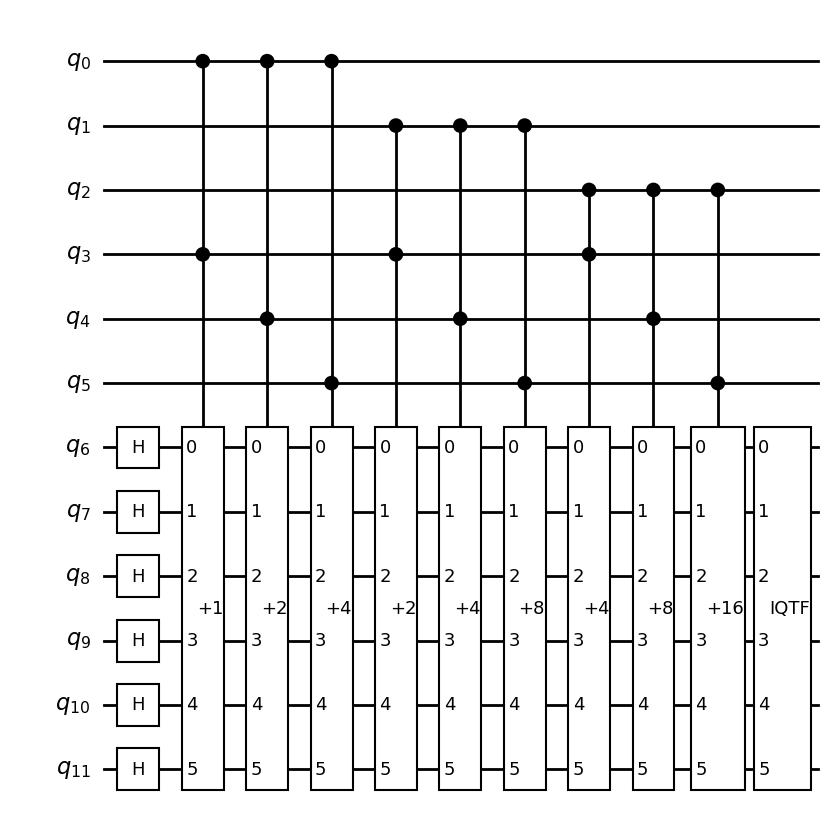

In [ ]:
def multiplier(qubits_in_first_operand, qubits_in_second_operand=None):
    
    # Se asume que la cantidad de qubits en el segundo operando
    # es igual a la cantidad en el primer operando.
    if qubits_in_second_operand == None:
        qubits_in_second_operand = qubits_in_first_operand
    
    # En el peor de los casos, la multiplicación de un operando de m bits y un operando
    # de n bits tiene como resultado a un número de m + n bits.
    result_qubits = qubits_in_first_operand + qubits_in_second_operand
    
    # Qubits totales dirigidos a operandos.
    operands_qubits = qubits_in_first_operand + qubits_in_second_operand
    
    # Qubits totales en el circuito.
    total_qubits = operands_qubits + result_qubits
    
    # Creación del circuito.
    quantum_circuit = QuantumCircuit(total_qubits, name=f"MUL")
    
    # Aplicación de Hadamard a los qubits resultado.
    for i in range(operands_qubits, total_qubits, 1):
        quantum_circuit.h(i)
        
    # Lista de compuertas a descomponer.
    gates_to_descompose = []
    
    for i in range(qubits_in_first_operand):
        
        # Valor del i-ésimo qubit del primer operando.
        first_operand_value = 2 ** i
        
        for j in range(qubits_in_second_operand):
            
            # Valor del j-ésimo qubit del segundo operando.
            second_operand_value = 2 ** j
            
            # Resultado de la multiplicación de los operandos.
            value_to_sum = first_operand_value * second_operand_value
            
            # Creación de la compuerta de suma.
            sum_gate = plusN(value_to_sum, result_qubits)
            
            # La columna es controlada por dos qubits: Xi e Yj.
            controlled_gate = sum_gate.control(2)
            
            # Se añade la compuerta controlada a la lista de compuertas a descomponer.
            if controlled_gate.name not in gates_to_descompose:
                gates_to_descompose.append(controlled_gate.name)
        
            # Se definen los "cables": [ControlX, ControlY, Objetivo1, Objetivo2, Objetivo3...].
            qubit_control = [i, j + qubits_in_first_operand] #Xi y Yj, respectivamente.
            qubits_objetivo = list(range(operands_qubits, total_qubits)) # Qubits del acumulador.
            
            # Cableado.
            wiring = qubit_control + qubits_objetivo
            
            # Agregado de la compuerta al circuito.
            quantum_circuit.append(controlled_gate, wiring)
    
    # Se descomponen las compuertas con controles de forma que Qiskit no genere
    # automáticamente una caja negra y pueda verse claramente quién activa cada compuerta.
    quantum_circuit = quantum_circuit.decompose(gates_to_decompose=gates_to_descompose)
        
    # Se añade la transformada cuántica de Fourier inversa para decodificar el resultado.
    quantum_circuit.append(iqtf(result_qubits), list(range(operands_qubits, total_qubits)))
    
    # Se retorna el circuito y la cantidad de qubits en el resultado.
    return quantum_circuit, result_qubits

qubits_in_operands = 3
qc, result_qubits = multiplier(qubits_in_operands)
qc.draw(output='mpl', style='bw')

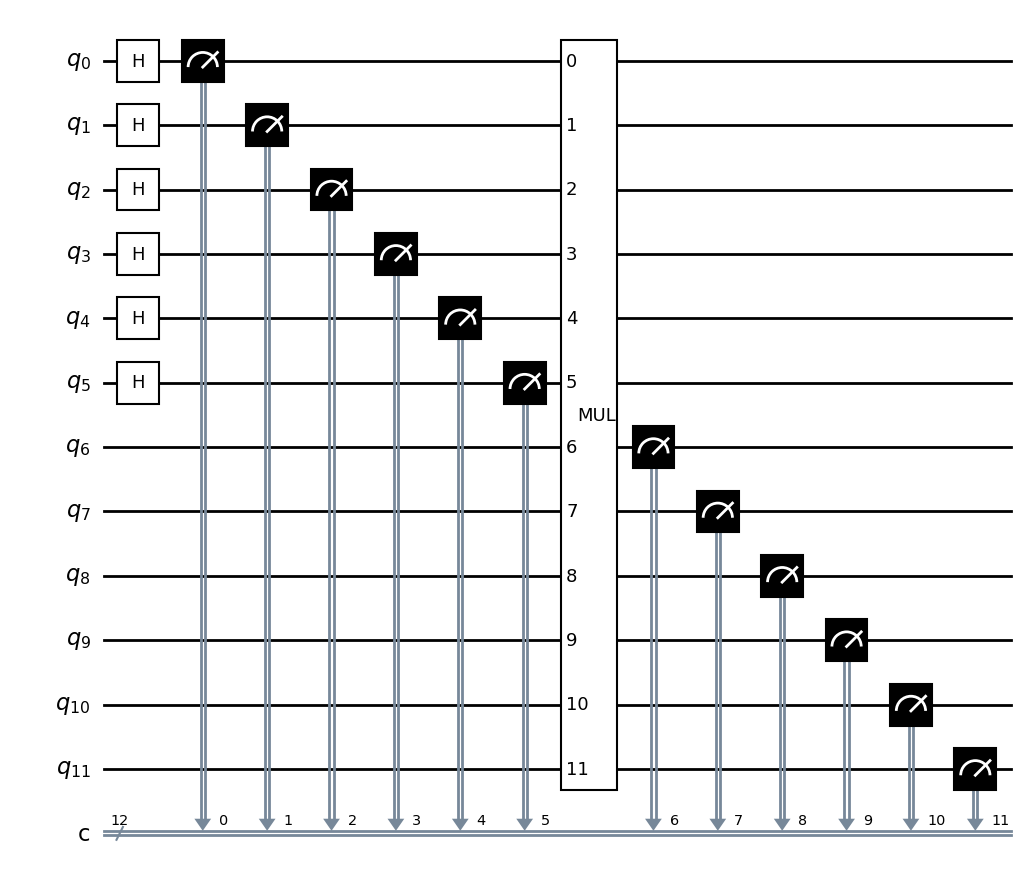

In [167]:
def add_measurements(input_qubits, result_qubits, quantum_circuit):
    
    total_qubits = input_qubits + result_qubits
    
    measured_quantum_circuit = QuantumCircuit(total_qubits, total_qubits)

    # Superposición de los operandos.
    measured_quantum_circuit.h(list(range(input_qubits)))

    # Medición de los valores de los operandos.
    measured_quantum_circuit.measure(list(range(input_qubits)), list(range(input_qubits)))

    measured_quantum_circuit.append(quantum_circuit, list(range(total_qubits)))

    # Se miden los resultados.
    for i in range(input_qubits, total_qubits, 1):
        measured_quantum_circuit.measure(i, i)
        
    return measured_quantum_circuit

measured_quantum_circuit = add_measurements(qubits_in_operands * 2, result_qubits, qc)
measured_quantum_circuit.draw(output='mpl', style='bw')

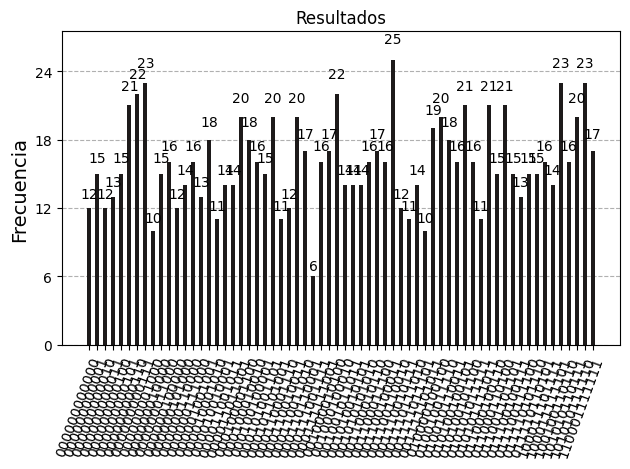

In [168]:
def simulate(measured_quantum_circuit):
    simulator = AerSimulator()
    transpiled = transpile(measured_quantum_circuit, simulator)
    job = simulator.run(transpiled, shots=1024)
    results = job.result()
    counts = results.get_counts(transpiled)

    histogram = plot_histogram(counts, title="Resultados", color="#1D1A1A")
    histogram.axes[0].set_ylabel("Frecuencia")

    return histogram, counts
    
histogram, counts = simulate(measured_quantum_circuit)
histogram

In [169]:
def print_multiplication_table(counts, n_qubits_a, n_qubits_b, n_bits_resultado):
    """
    Imprime una tabla de verdad para la multiplicación de dos operandos.
    Formato del string esperado de Qiskit: [Resultado] [Operando B] [Operando A].
    """
    
    # Configuración de anchos.
    W_QUBIT = 4   
    W_FREQ = 10   
    W_CHECK = 8  
    W_EXPECTED = 8 
    
    # Generación de headers dinámicos.
    # A está al final (derecha) en el string de qiskit (qubits 0..2).
    headers_a = [f"A{i}" for i in reversed(range(n_qubits_a))]
    # B está en el medio (qubits 3..5).
    headers_b = [f"B{i}" for i in reversed(range(n_qubits_b))]
    # S (Resultado) está a la izquierda (qubits 6..11).
    headers_out = [f"S{i}" for i in reversed(range(n_bits_resultado))]
    
    total_input_cols = n_qubits_a + n_qubits_b
    total_cols = total_input_cols + n_bits_resultado
    
    # Se calcula el ancho total para la línea horizontal.
    # Se suman los espacios extra para los separadores '|' y '||'.
    TOTAL_WIDTH = (total_cols * (W_QUBIT + 3)) + W_FREQ + W_CHECK + W_EXPECTED + 12

    def print_line():
        print(f"|{'-' * (TOTAL_WIDTH - 2)}|")

    # Impresión del encabezado.
    print_line()
    title = f"Validación: Multiplicación (A x B = S)"
    print(f"|{title:^{TOTAL_WIDTH - 2}}|")
    print_line()

    # Construcción de la fila de títulos.
    header_str = "|"
    
    # Header B.
    for h in headers_b: header_str += f" {h:^{W_QUBIT}} |"
    header_str += "|" # Separador entre operandos
    # Header A.
    for h in headers_a: header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += "|" # Separador Inputs/Outputs.
    
    # Header Salida.
    for h in headers_out: header_str += f" {h:^{W_QUBIT}} |"
    
    header_str += f" {'Freq':^{W_FREQ}} | {'Esp.':^{W_EXPECTED}} | {'¿OK?':^{W_CHECK}} |"
    print(header_str)
    print_line()

    # Procesamiento de datos.
    for bitstring, count in sorted(counts.items()):
        
        clean_bits = bitstring.replace(" ", "")
        
        # Extracción del operando A (los últimos bits).
        idx_start_a = -n_qubits_a
        chars_a = clean_bits[idx_start_a:]
        
        # Extracción del operando B (bits previos a A).
        idx_start_b = -(n_qubits_a + n_qubits_b)
        idx_end_b = -n_qubits_a
        chars_b = clean_bits[idx_start_b : idx_end_b]
        
        # Extracción del resultado (bits previos a B).
        idx_start_out = -(n_qubits_a + n_qubits_b + n_bits_resultado)
        idx_end_out = -(n_qubits_a + n_qubits_b)
        chars_out = clean_bits[idx_start_out : idx_end_out]
        
        # Conversión y validación.
        val_a = int(chars_a, 2)
        val_b = int(chars_b, 2)
        val_real = int(chars_out, 2)
        
        # Lógica de multiplicación.
        val_esperado = val_a * val_b
        
        es_correcto = "Sí" if val_esperado == val_real else "No"

        # Impresión.
        # Conversión de strings a listas para iterar visualmente.
        bits_a = list(chars_a)
        bits_b = list(chars_b)
        bits_out = list(chars_out)
        
        row_str = "|"
        
        # Impresión de B.
        for b in bits_b: row_str += f" {b:^{W_QUBIT}} |"
        row_str += "|"
        # Impresión de A.
        for b in bits_a: row_str += f" {b:^{W_QUBIT}} |"
        
        row_str += "|" 
        
        # Impresión de los resultados.
        for b in bits_out: row_str += f" {b:^{W_QUBIT}} |"
            
        row_str += f" {count:^{W_FREQ}} | {val_esperado:^{W_EXPECTED}} | {es_correcto:^{W_CHECK}} |"
        print(row_str)

    print_line()

Impresión de la tabla de verdad:

In [170]:
print_multiplication_table(
    counts, 
    n_qubits_a=qubits_in_operands, 
    n_qubits_b=qubits_in_operands, 
    n_bits_resultado=result_qubits
)

|------------------------------------------------------------------------------------------------------------------------|
|                                         Validación: Multiplicación (A x B = S)                                         |
|------------------------------------------------------------------------------------------------------------------------|
|  B2  |  B1  |  B0  ||  A2  |  A1  |  A0  ||  S5  |  S4  |  S3  |  S2  |  S1  |  S0  |    Freq    |   Esp.   |   ¿OK?   |
|------------------------------------------------------------------------------------------------------------------------|
|  0   |  0   |  0   ||  0   |  0   |  0   ||  0   |  0   |  0   |  0   |  0   |  0   |     12     |    0     |    Sí    |
|  0   |  0   |  0   ||  0   |  0   |  1   ||  0   |  0   |  0   |  0   |  0   |  0   |     15     |    0     |    Sí    |
|  0   |  0   |  0   ||  0   |  1   |  0   ||  0   |  0   |  0   |  0   |  0   |  0   |     12     |    0     |    Sí    |
|  0   |  0   | 

El resultado

Guardado: ../outputs/validacion_mul_parte_1.png


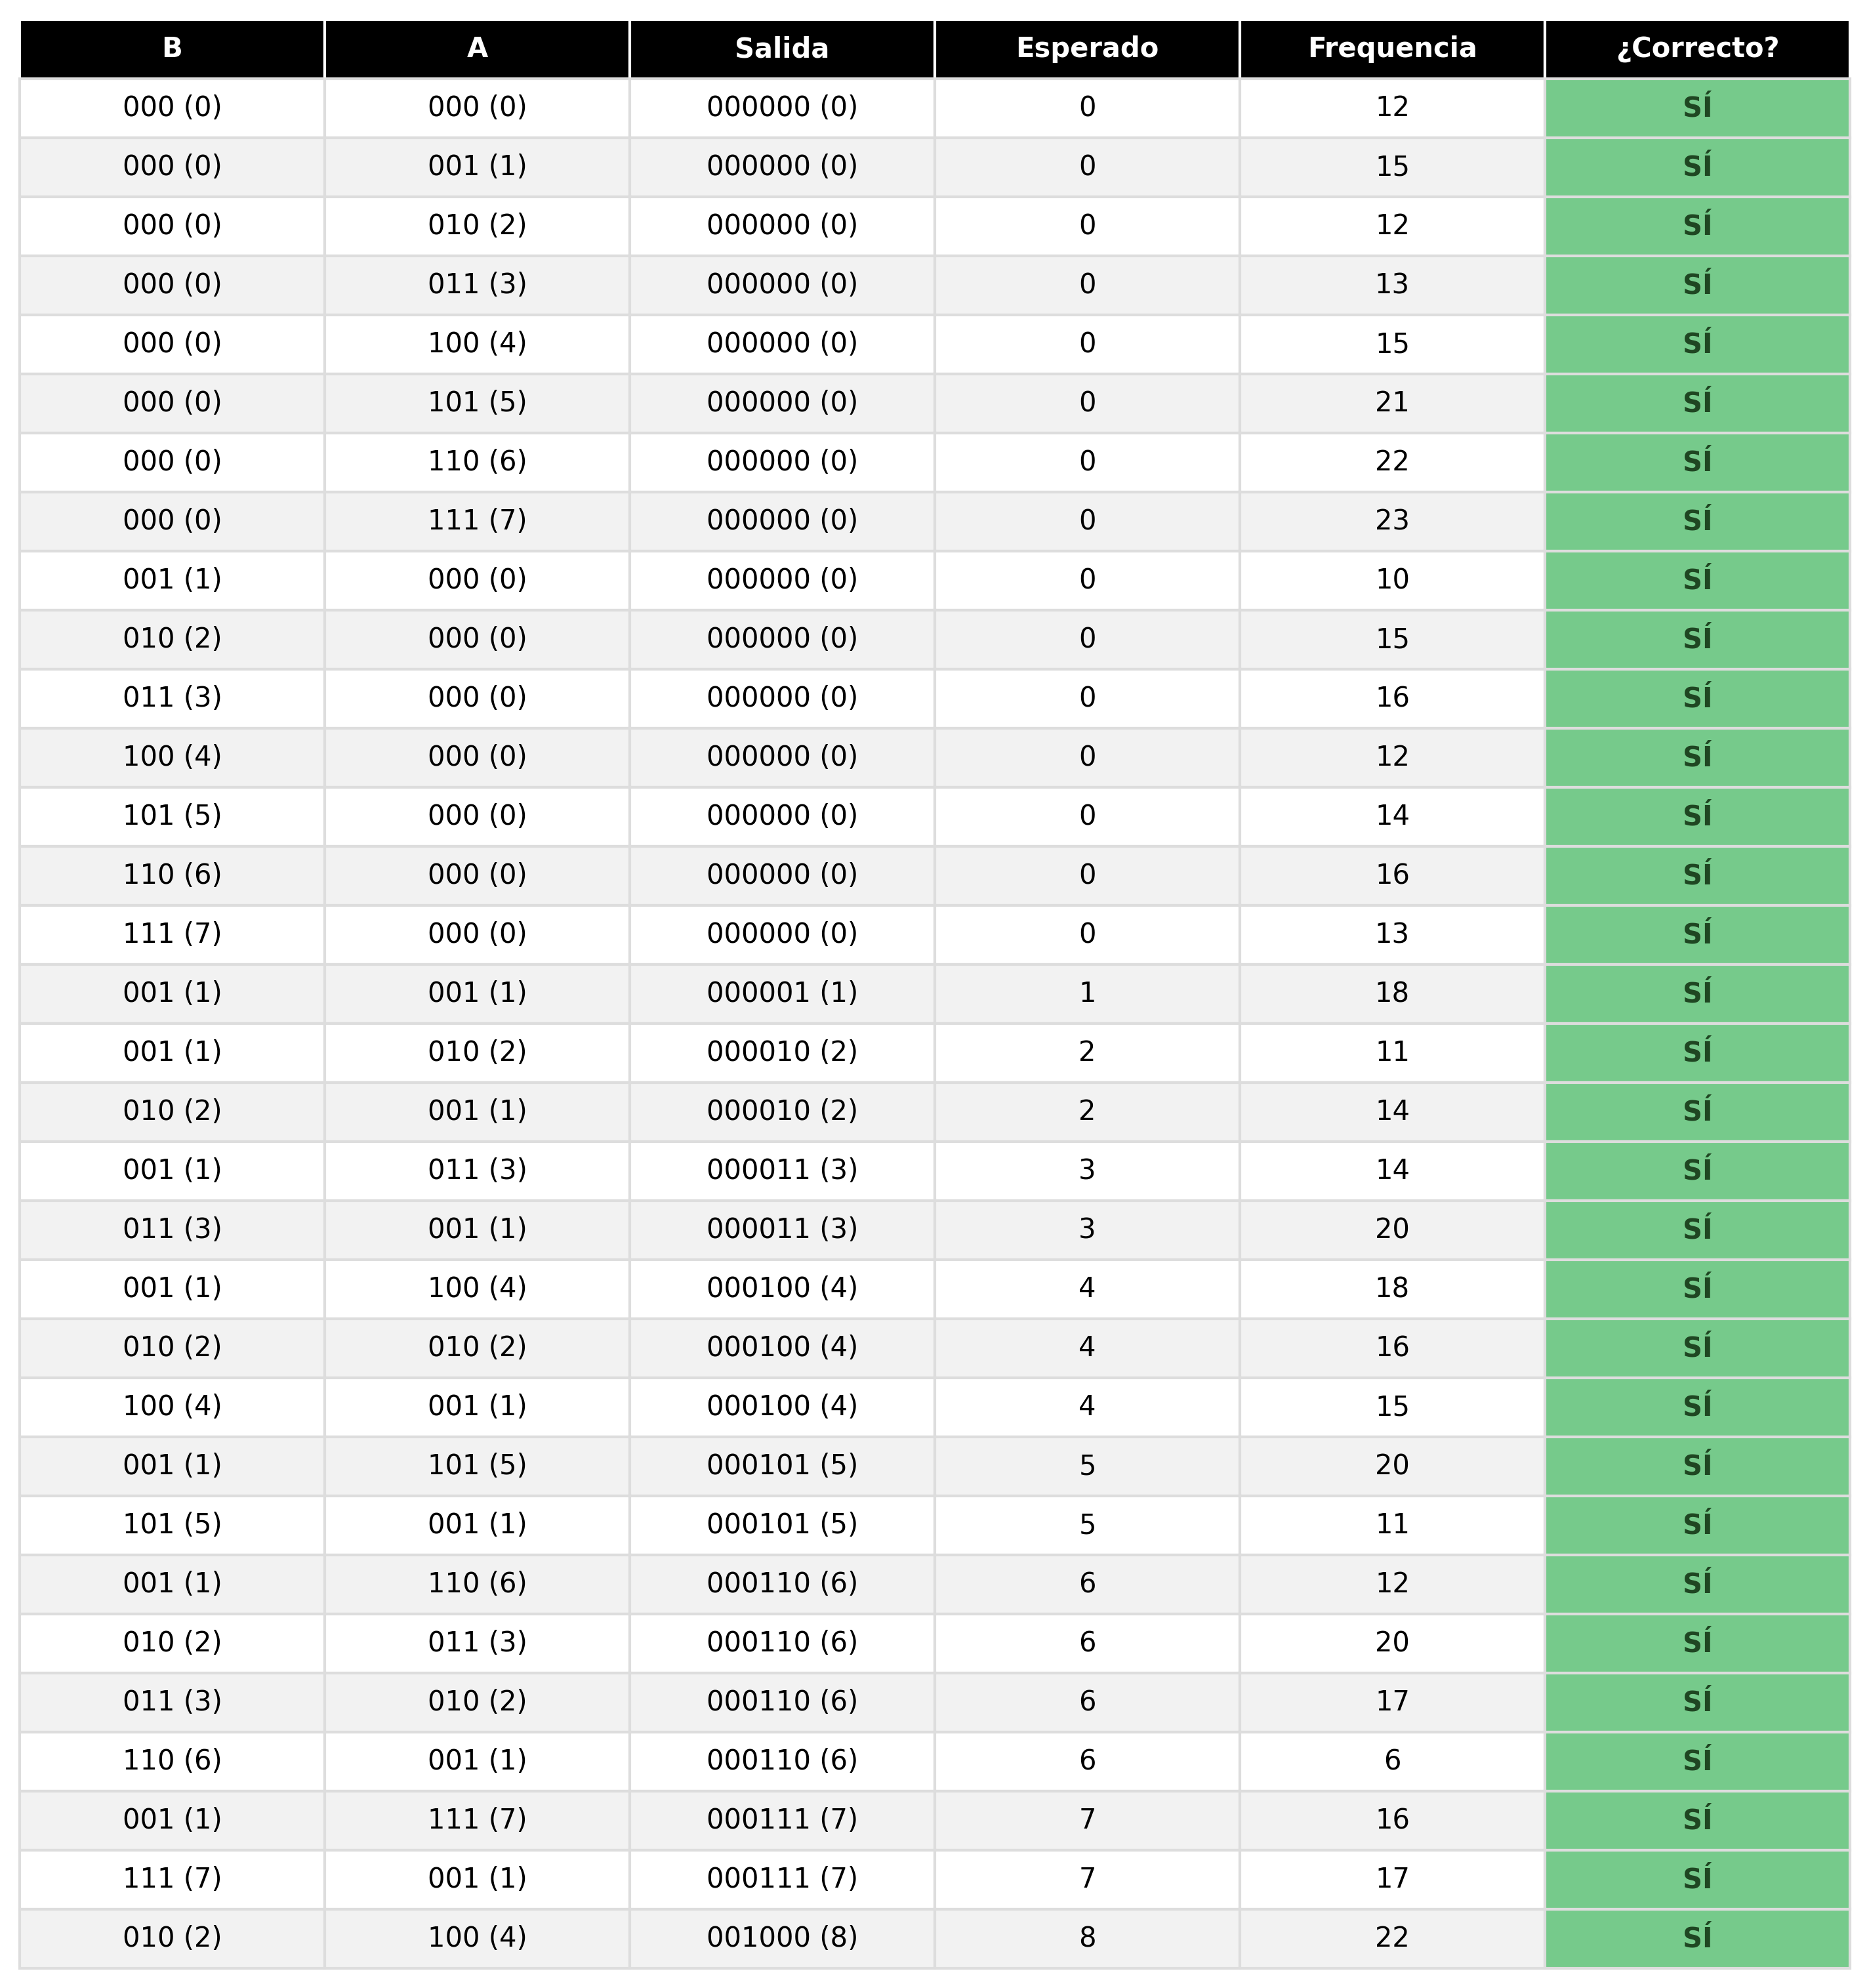

Guardado: ../outputs/validacion_mul_parte_2.png


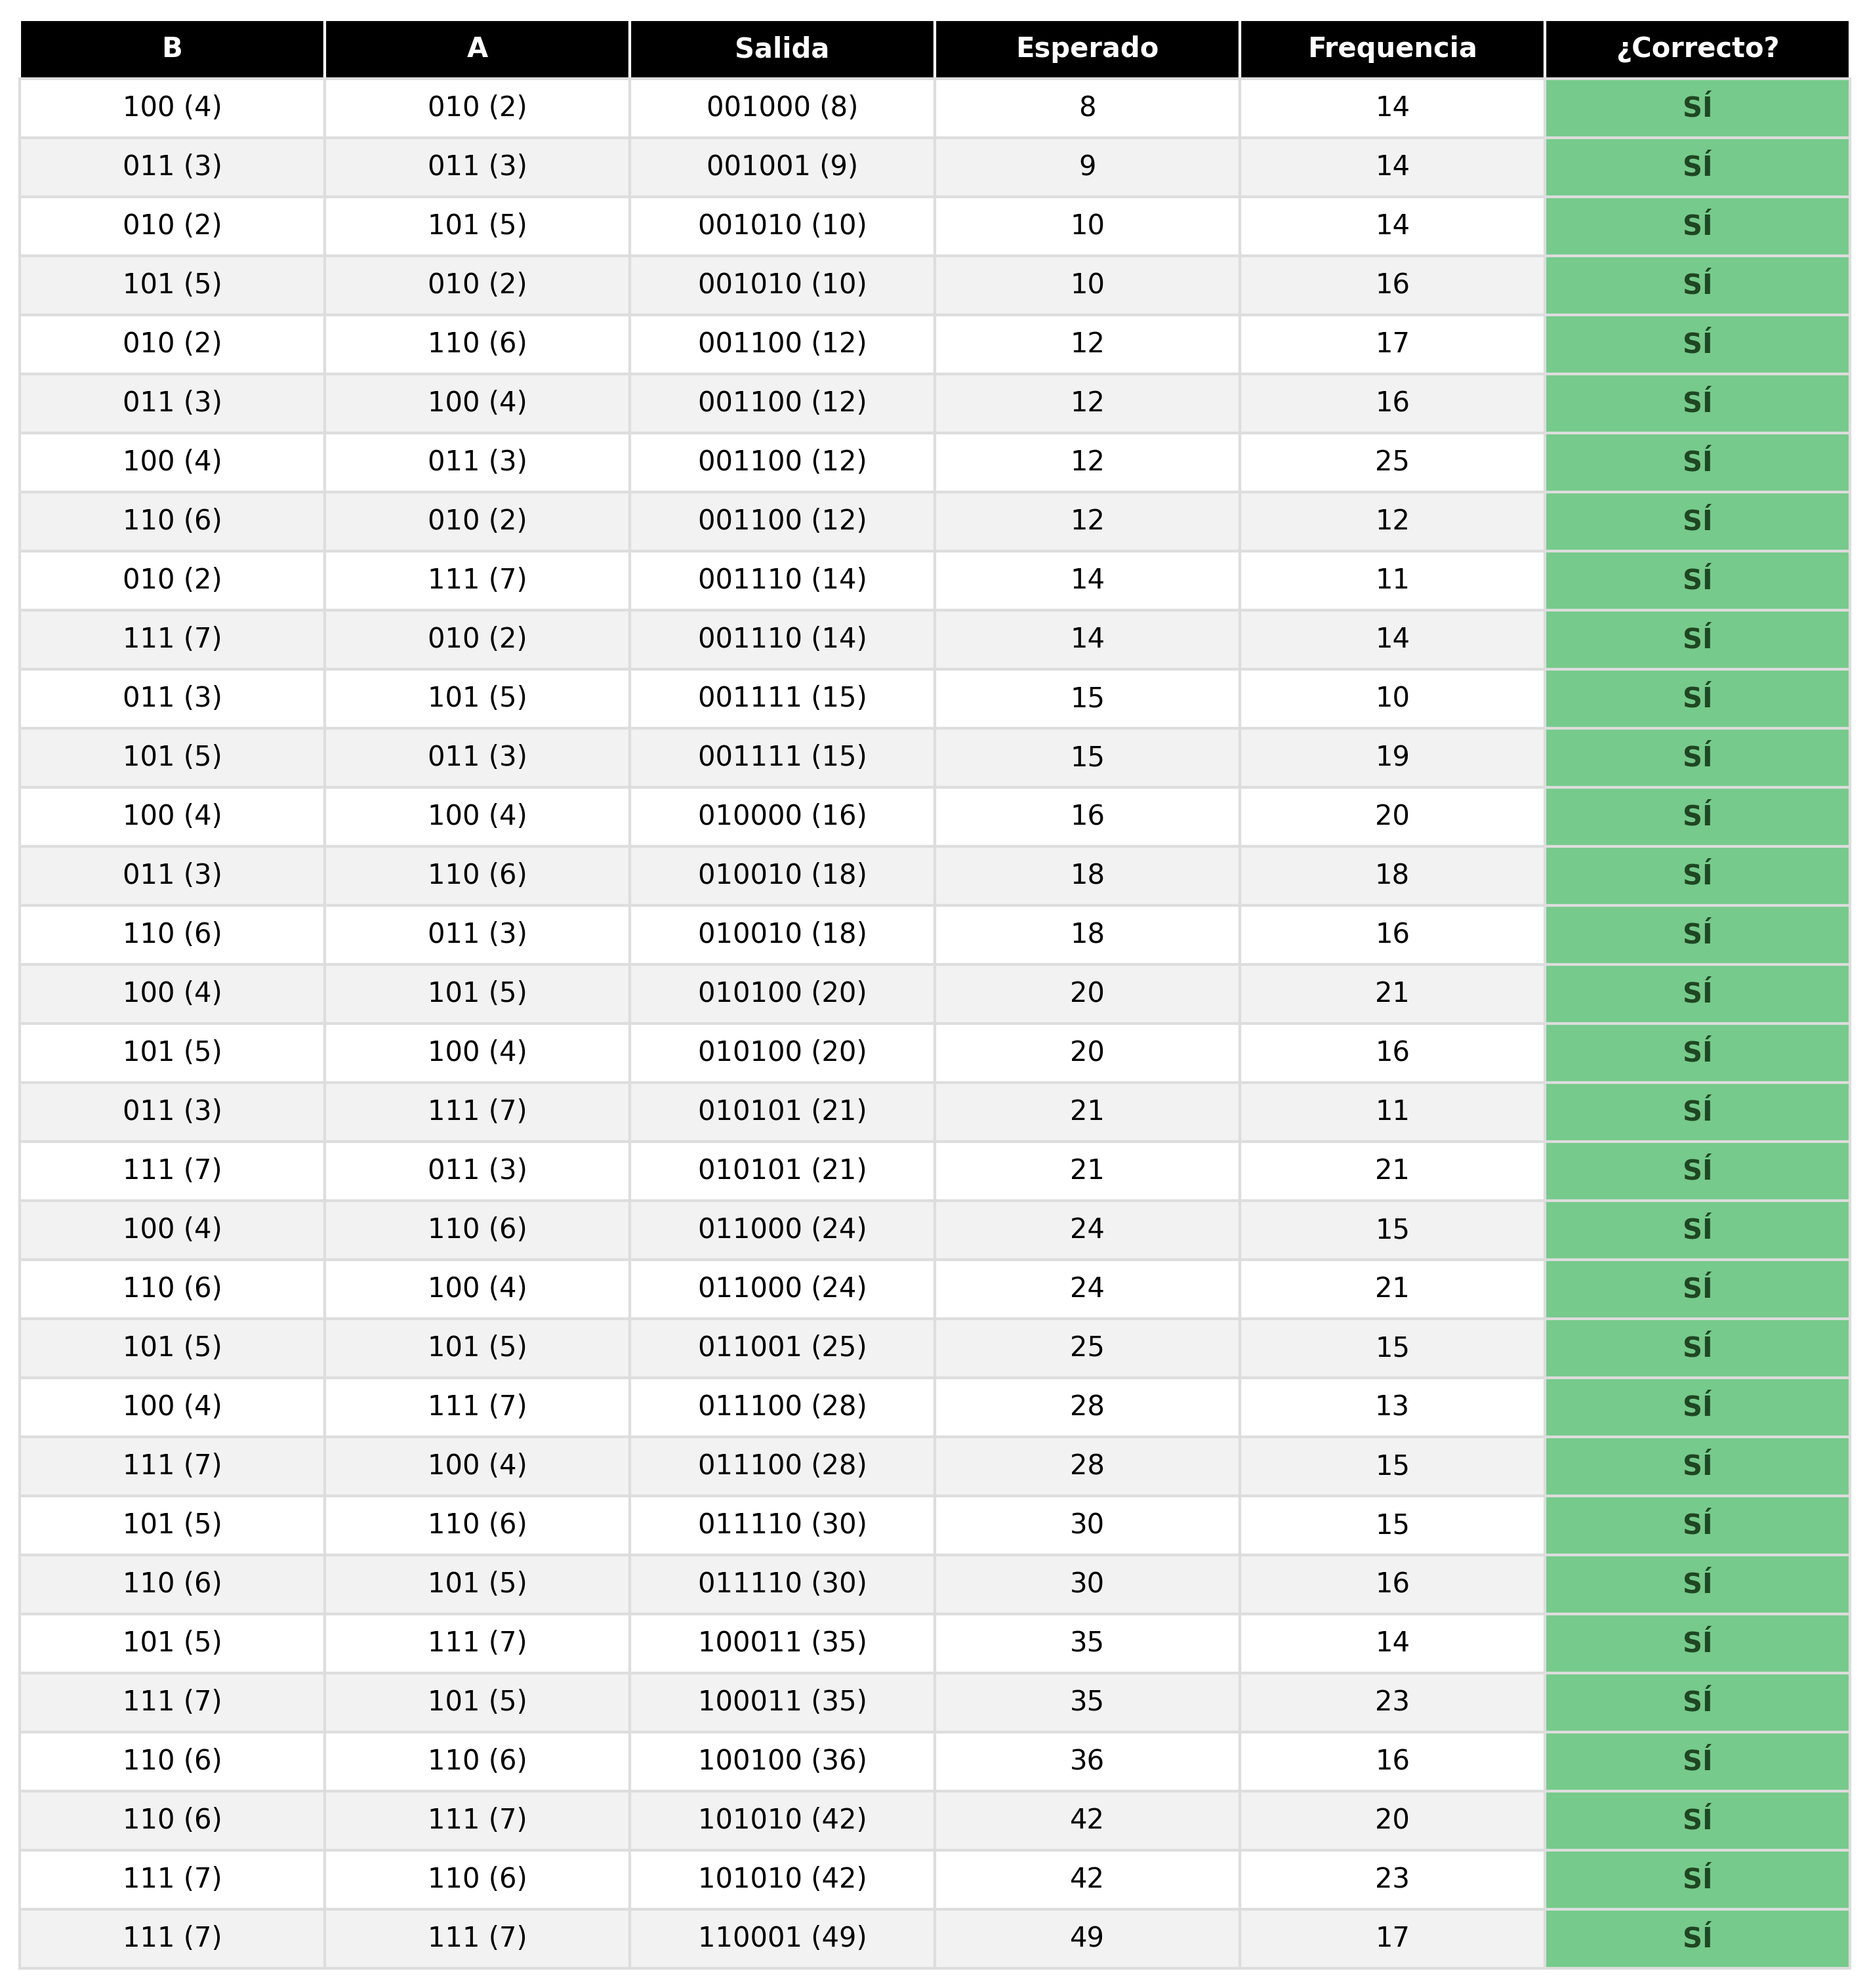

In [171]:


def save_report_table(counts, n_qubits_a, n_qubits_b, n_bits_resultado, filename_base="tabla_mul", max_rows=32):
    """
    Genera múltiples imágenes PNG de alta resolución en la que se presenta una tabla.
    """
    
    # Preparación de los datos.
    data = []
    column_labels = ["B", "A", "Salida", "Esperado", "Frequencia", "¿Correcto?"]
    
    for bitstring, count in sorted(counts.items()):
        clean_bits = bitstring.replace(" ", "")
        
        chars_a = clean_bits[-n_qubits_a:]
        chars_b = clean_bits[-(n_qubits_a + n_qubits_b) : -n_qubits_a]
        chars_out = clean_bits[-(n_qubits_a + n_qubits_b + n_bits_resultado) : -(n_qubits_a + n_qubits_b)]
        
        val_a = int(chars_a, 2)
        val_b = int(chars_b, 2)
        val_real = int(chars_out, 2)
        val_esperado = val_a * val_b
        
        es_correcto = val_esperado == val_real
        status_text = "SÍ" if es_correcto else "NO"
        
        row = [
            f"{chars_b} ({val_b})",
            f"{chars_a} ({val_a})",
            f"{chars_out} ({val_real})",
            val_esperado,
            count,
            status_text
        ]
        data.append(row)

    # Lógica de División (Chunking).
    total_rows = len(data)
    
    # Se calculan cuántas partes se necesitan.
    num_parts = math.ceil(total_rows / max_rows)

    for i in range(num_parts):
        
        # Se definen el inicio y fin del corte.
        start = i * max_rows
        end = start + max_rows
        
        # Se cortan los datos.
        subset_data = data[start:end]
        
        # Generación de la figura para la parte.
        rows_in_subset = len(subset_data)
        fig_height = max(2, rows_in_subset * 0.1) + 1 # +1 para el header.
        
        _, ax = plt.subplots(figsize=(10, fig_height))
        ax.axis('tight')
        ax.axis('off')
        
        # Creación de la tabla.
        table = ax.table(cellText=subset_data, colLabels=column_labels, cellLoc='center', loc='center')
        
        # Estilizado.
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.8) # Un poco más de alto para que respire

        # Coloreado.
        for (r, c), cell in table.get_celld().items():
            if r == 0: # Header.
                cell.set_text_props(weight='bold', color='white')
                cell.set_facecolor("#000000")
                cell.set_edgecolor('white')
            else: # Datos.
                cell.set_edgecolor('#dddddd')
                
                if c == 5: 
                    # Si bien subset_data empieza en 0, la tabla tiene header, por lo que se empieza en r-1.
                    text_val = subset_data[r-1][5]
                    
                    if text_val == "SÍ":
                        cell.set_facecolor("#76CA8B")
                        cell.set_text_props(color="#1F4622", weight='bold')
                    else:
                        cell.set_facecolor('#f8d7da')
                        cell.set_text_props(color='#842029', weight='bold')
                else:
                    if r % 2 == 0:
                        cell.set_facecolor('#f2f2f2')
                    else:
                        cell.set_facecolor('white')
                        
        output_directory = "../outputs"
                        
        # Crea el directorio si no existe. 
        # "exist_ok=True" evita el error si ya existe.
        os.makedirs(output_directory, exist_ok=True)

        # Nombre del archivo, especificando la parte.
        current_filename = f"{output_directory}/{filename_base}_parte_{i+1}.png"
        
        # Título.
        # plt.title(f"Tabla de Verdad - Parte {i+1} de {num_parts}", pad=10, fontsize=12, color="#555555")
        
        # Guardado de la tabla en imágenes.
        plt.savefig(current_filename, bbox_inches='tight', dpi=300)
        plt.close()
        
        print(f"Guardado: {current_filename}")
        
        # Se muestra en la notebooks el resultado.
        from IPython.display import display, Image
        display(Image(current_filename))

save_report_table(counts, 3, 3, 6, filename_base="validacion_mul", max_rows=32)